In [9]:
import pysam
import numpy as np
import pandas as pd
import os

# --- Konfiguration ---
# Passe diese Pfade an deine Dateistruktur an
BAM_FILES = {
    'Sample_1': '/home/kai/Documents/00_RNA/00_riboHMM_simple/00_BAMs/uf_muellermcnicoll_2025_04_01_huvec_dnor_2_dedup.bam',
    'Sample_2': '/home/kai/Documents/00_RNA/00_riboHMM_simple/00_BAMs/uf_muellermcnicoll_2025_04_02_huvec_dnor_3_dedup.bam',
    'Sample_3': '/home/kai/Documents/00_RNA/00_riboHMM_simple/00_BAMs/uf_muellermcnicoll_2025_04_03_huvec_dnor_4_dedup.bam'
}
# Das ist die entscheidende Referenzdatei!
FASTA_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/02_Reference_Files/MANE.GRCh38.v0.95.select_ensembl_rna.fna' 

def get_transcript_lengths_from_fasta(fasta_path):
    """
    Liest eine FASTA-Datei und gibt ein Dictionary mit den Längen aller Transkripte zurück.
    Schlüssel: Transkript-ID, Wert: Länge in Nukleotiden.
    """
    print(f"Lese Transkriptlängen aus {fasta_path}...")
    if not os.path.exists(fasta_path):
        print(f"❌ Fehler: FASTA-Datei nicht gefunden: {fasta_path}")
        return None
    try:
        # pysam.FastaFile öffnet die Datei und erstellt bei Bedarf einen Index (.fai)
        with pysam.FastaFile(fasta_path) as fasta:
            lengths = {name: fasta.get_reference_length(name) for name in fasta.references}
        print(f"✅ {len(lengths)} Transkripte gefunden.")
        return lengths
    except Exception as e:
        print(f"❌ Ein Fehler ist beim Lesen der FASTA-Datei aufgetreten: {e}")
        return None

# Lade die Längen aller Transkripte. Dieses Dictionary ist unsere Grundlage.
transcript_lengths = get_transcript_lengths_from_fasta(FASTA_FILE)

# Wenn die Datei nicht gefunden wurde, brechen wir hier ab.
if transcript_lengths is None:
    exit()

# Beispielausgabe, wie das Dictionary aussieht:
print(list(transcript_lengths.items())[:3])
# -> [('ENST00000456328.2', 1342), ('ENST00000450305.2', 632), ('ENST00000488147.1', 1341)]

Lese Transkriptlängen aus /home/kai/Documents/00_RNA/00_riboHMM_simple/02_Reference_Files/MANE.GRCh38.v0.95.select_ensembl_rna.fna...
✅ 18640 Transkripte gefunden.
[('ENST00000641515.2', 2618), ('ENST00000426406.4', 939), ('ENST00000332831.5', 939)]


In [10]:
from collections import Counter

INTERMEDIATE_DIR = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data'

def find_most_frequent_read_length(bam_files_dict):
    """
    Durchsucht alle BAM-Dateien und findet die global häufigste Read-Länge.
    """
    print("Starte Suche nach der häufigsten Read-Länge über alle Samples...")
    length_counts = Counter()
    
    for sample_name, bam_path in bam_files_dict.items():
        print(f"Analysiere Längen in: {os.path.basename(bam_path)}...")
        with pysam.AlignmentFile(bam_path, "rb") as bamfile:
            # Iteriere über alle Reads und zähle ihre Längen
            for read in bamfile.fetch(until_eof=True):
                if not read.is_unmapped:
                    length_counts.update([read.query_alignment_length])
    
    # Finde die häufigste Länge aus dem Counter
    most_common_length, count = length_counts.most_common(3)[0]
    
    print(f"\n✅ Suche abgeschlossen.")
    print(length_counts.most_common(3))
    print(f"Die häufigste Read-Länge ist: {most_common_length} nt (kam {count:,} mal vor).")
    return most_common_length

# Führe Schritt 1 aus
target_length = find_most_frequent_read_length(BAM_FILES)


Starte Suche nach der häufigsten Read-Länge über alle Samples...
Analysiere Längen in: uf_muellermcnicoll_2025_04_01_huvec_dnor_2_dedup.bam...
Analysiere Längen in: uf_muellermcnicoll_2025_04_02_huvec_dnor_3_dedup.bam...
Analysiere Längen in: uf_muellermcnicoll_2025_04_03_huvec_dnor_4_dedup.bam...

✅ Suche abgeschlossen.
[(38, 1691317), (37, 1688855), (36, 1535479)]
Die häufigste Read-Länge ist: 38 nt (kam 1,691,317 mal vor).


In [11]:
import pysam

# --- Konfiguration ---
BAM_FILE_IN = BAM_FILES['Sample_1']
BED_FILE_OUT = '/home/kai/Documents/00_RNA/00_riboHMM_simple/00_BAMs/probe1_reads.bed'

def convert_bam_to_bed(bam_path, bed_path):
    """
    Konvertiert eine BAM-Datei in eine BED6-Datei.
    
    BED6-Format:
    1. Chromosom (Transkript-ID)
    2. Start-Position
    3. End-Position
    4. Name (Read-Name)
    5. Score (Mapping-Qualität)
    6. Strang (+ oder -)
    """
    print(f"Konvertiere {bam_path} zu {bed_path}...")
    
    with pysam.AlignmentFile(bam_path, "rb") as bamfile, open(bed_path, 'w') as bedfile:
        # Iteriere über alle ausgerichteten Reads
        for read in bamfile.fetch(until_eof=True):
            if read.is_unmapped:
                continue
            
            # Extrahiere die benötigten Informationen
            chrom = read.reference_name
            start = read.reference_start
            end = read.reference_end
            name = read.query_name
            score = read.mapping_quality
            strand = '-' if read.is_reverse else '+'
            read_length = read.query_length
            
            # Schreibe die formatierte Zeile in die BED-Datei
            bed_line = f"{chrom}\t{start}\t{end}\t{name}\t{score}\t{strand}\t{read_length}\n"
            bedfile.write(bed_line)
            
    print(f"✅ Konvertierung abgeschlossen. Datei gespeichert: {bed_path}")

# Führe die Konvertierung aus
convert_bam_to_bed(BAM_FILE_IN, BED_FILE_OUT)

Konvertiere /home/kai/Documents/00_RNA/00_riboHMM_simple/00_BAMs/uf_muellermcnicoll_2025_04_01_huvec_dnor_2_dedup.bam zu /home/kai/Documents/00_RNA/00_riboHMM_simple/00_BAMs/probe1_reads.bed...
✅ Konvertierung abgeschlossen. Datei gespeichert: /home/kai/Documents/00_RNA/00_riboHMM_simple/00_BAMs/probe1_reads.bed


In [12]:
import pysam
import pandas as pd
from collections import defaultdict
import os

def save_filtered_counts_to_tsv(bam_path, output_tsv_path, target_read_length):
    """
    Zählt 5'-Reads aus einer BAM-Datei, aber NUR für Reads mit der 
    angegebenen ZIEL-LÄNGE.
    """
    print(f"Verarbeite: {os.path.basename(bam_path)} (Filter für Länge {target_read_length} nt)...")
    
    sparse_counts = defaultdict(lambda: defaultdict(int))

    with pysam.AlignmentFile(bam_path, "rb") as bamfile:
        for read in bamfile.fetch(until_eof=True):
            # --- HIER IST DER NEUE FILTER ---
            if read.is_unmapped or read.query_alignment_length != target_read_length:
                continue
            
            if read.is_reverse: # Ignoriere Reverse-Strand zur Vereinfachung
                continue

            sparse_counts[read.reference_name][read.reference_start] += 1

    print(f"Schreibe gefilterte Zählungen nach: {os.path.basename(output_tsv_path)}...")
    with open(output_tsv_path, 'w') as f:
        f.write("transcript_id\tposition\tcount\n")
        for transcript_id, positions in sparse_counts.items():
            for pos, count in positions.items():
                f.write(f"{transcript_id}\t{pos}\t{count}\n")
    print("✅ Abgeschlossen.")


# Führe Schritt 2 für alle BAM-Dateien mit der gefundenen Ziellänge aus
intermediate_files = {}
for sample_name, bam_path in BAM_FILES.items():
    output_path = os.path.join(INTERMEDIATE_DIR, f"{sample_name}_counts_len{target_length}.tsv")
    save_filtered_counts_to_tsv(bam_path, output_path, target_length)
    intermediate_files[sample_name] = output_path

Verarbeite: uf_muellermcnicoll_2025_04_01_huvec_dnor_2_dedup.bam (Filter für Länge 38 nt)...
Schreibe gefilterte Zählungen nach: Sample_1_counts_len38.tsv...
✅ Abgeschlossen.
Verarbeite: uf_muellermcnicoll_2025_04_02_huvec_dnor_3_dedup.bam (Filter für Länge 38 nt)...
Schreibe gefilterte Zählungen nach: Sample_2_counts_len38.tsv...
✅ Abgeschlossen.
Verarbeite: uf_muellermcnicoll_2025_04_03_huvec_dnor_4_dedup.bam (Filter für Länge 38 nt)...
Schreibe gefilterte Zählungen nach: Sample_3_counts_len38.tsv...
✅ Abgeschlossen.


In [13]:
print("\n--- Schritt 3: Führe alle gefilterten Zähl-Dateien zusammen ---")

sample_names = list(BAM_FILES.keys())
base_sample_name = sample_names[0]
base_file_path = intermediate_files[base_sample_name]

print(f"Lade Basis-Datei: {os.path.basename(base_file_path)}")
merged_df = pd.read_csv(base_file_path, sep='\t').rename(columns={'count': base_sample_name})

for i in range(1, len(sample_names)):
    sample_name = sample_names[i]
    file_path = intermediate_files[sample_name]
    
    print(f"Merge mit: {os.path.basename(file_path)}")
    next_df = pd.read_csv(file_path, sep='\t').rename(columns={'count': sample_name})
    
    merged_df = pd.merge(
        merged_df,
        next_df,
        on=['transcript_id', 'position'],
        how='outer'
    )

print("Räume die finale Tabelle auf und speichere...")
merged_df = merged_df.set_index(['transcript_id', 'position'])
merged_df = merged_df.fillna(0).astype(int)
merged_df = merged_df.sort_index()

output_filename = f'/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/filtered_len{target_length}_raw_counts_wide.csv'
merged_df.to_csv(output_filename)

print(f"\n✅ Analyse abgeschlossen! Finale gefilterte Tabelle in '{output_filename}' gespeichert.")
print(merged_df.head())


--- Schritt 3: Führe alle gefilterten Zähl-Dateien zusammen ---
Lade Basis-Datei: Sample_1_counts_len38.tsv
Merge mit: Sample_2_counts_len38.tsv
Merge mit: Sample_3_counts_len38.tsv
Räume die finale Tabelle auf und speichere...

✅ Analyse abgeschlossen! Finale gefilterte Tabelle in '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/filtered_len38_raw_counts_wide.csv' gespeichert.
                             Sample_1  Sample_2  Sample_3
transcript_id      position                              
ENST00000000233.10 111              1         0         0
                   113              0         0         1
                   114              0         1         0
                   116              0         0         1
                   129              0         1         0


In [18]:
import pandas as pd

# --- Konfiguration ---
# Die Eingabedatei aus dem vorherigen Schritt
INPUT_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/filtered_len38_raw_counts_wide.csv'
# Name der finalen Ausgabedatei
OUTPUT_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/summed_filtered_len38_raw_counts.csv'


# 1. Lade die breite Tabelle mit den Rohzählungen
print(f"Lade Daten aus '{INPUT_FILE}'...")
# Wichtig: Wir definieren die ersten beiden Spalten als Index
raw_counts_df = pd.read_csv(INPUT_FILE, index_col=['transcript_id', 'position'])


# 2. Summiere die Zählungen über alle Spalten (Samples)
# axis=1 bedeutet "summiere entlang der Spalten für jede Zeile"
print("Summiere Reads über alle Samples...")
total_sum = raw_counts_df.sum(axis=1)


# 3. Konvertiere die Ergebnis-Serie in einen DataFrame und speichere sie
# Wir geben der Spalte einen aussagekräftigen Namen
summed_df = total_sum.to_frame(name='total_reads')


# 4. Speichere die finale Datei
summed_df.to_csv(OUTPUT_FILE)

print(f"\n✅ Fertig! Die aufsummierten Reads wurden in '{OUTPUT_FILE}' gespeichert.")
print("Struktur der finalen Datei:")
print(summed_df.head())

Lade Daten aus '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/filtered_len38_raw_counts_wide.csv'...
Summiere Reads über alle Samples...

✅ Fertig! Die aufsummierten Reads wurden in '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/summed_filtered_len38_raw_counts.csv' gespeichert.
Struktur der finalen Datei:
                             total_reads
transcript_id      position             
ENST00000000233.10 111                 1
                   113                 1
                   114                 1
                   116                 1
                   129                 1


In [19]:
import numpy as np
import pandas as pd
import pysam
import os
from tqdm import tqdm

# --- KONSTANTEN UND DATEIPFADE ---
# Die Pfade wurden entsprechend deiner Beschreibung angepasst
FASTA_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/02_Reference_Files/MANE.GRCh38.v0.95.select_ensembl_rna.fna'
COUNTS_CSV_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/summed_filtered_len38_raw_counts.csv'
PROCESSED_DATA_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/ribosome_counts.npz'

# --- DATENVERARBEITUNGSFUNKTIONEN ---

def get_transcript_lengths_from_fasta(fasta_path):
    """
    Liest eine FASTA-Datei und gibt ein Dictionary mit den Längen aller Transkripte zurück.
    """
    print(f"Lese Transkriptlängen aus {fasta_path}...")
    if not os.path.exists(fasta_path):
        print(f"❌ Fehler: FASTA-Datei nicht gefunden: {fasta_path}")
        return None
    try:
        with pysam.FastaFile(fasta_path) as fasta:
            references = fasta.references
            lengths = {
                name: fasta.get_reference_length(name) 
                for name in tqdm(references, desc="Lese FASTA-Referenzen")
            }
        print(f"✅ {len(lengths)} Transkripte gefunden.")
        return lengths
    except Exception as e:
        print(f"❌ Ein Fehler ist beim Lesen der FASTA-Datei aufgetreten: {e}")
        return None

def process_counts_to_arrays(counts_csv_path, transcript_lengths):
    """
    Konvertiert Zähldaten aus einem 'long' CSV-Format in ein Dictionary von NumPy-Arrays.
    """
    print(f"Verarbeite 'long' Zähldaten aus {counts_csv_path}...")
    try:
        counts_df = pd.read_csv(counts_csv_path)
        print("✅ CSV-Datei erfolgreich geladen.")
    except FileNotFoundError:
        print(f"❌ Fehler: CSV-Datei nicht gefunden: {counts_csv_path}")
        return None

    # Initialisiere das Dictionary mit Null-Arrays für jedes Transkript
    transcript_data = {
        tid: np.zeros(length, dtype=np.uint16)
        for tid, length in transcript_lengths.items()
    }
    print(f"Initialisiere Arrays für {len(transcript_data)} Transkripte.")

    processed_count = 0
    # Iteriere über die Zeilen der CSV-Datei (long format)
    for _, row in tqdm(counts_df.iterrows(), total=len(counts_df), desc="Verarbeite CSV-Einträge"):
        tid = row['transcript_id']
        pos = int(row['position'])
        reads = int(row['total_reads'])
        
        if tid in transcript_data:
            # Stelle sicher, dass die Position innerhalb der Transkriptlänge liegt
            if 0 <= pos < transcript_data[tid].shape[0]:
                transcript_data[tid][pos] = reads
                processed_count += 1

    print(f"✅ Daten für {len(transcript_data)} Transkripte fertig verarbeitet. {processed_count} Einträge zugewiesen.")
    return transcript_data


def save_processed_data(data_dict, file_path):
    """Speichert das Dictionary mit NumPy-Arrays komprimiert im .npz-Format."""
    print(f"Speichere verarbeitete Daten nach {file_path}...")
    np.savez_compressed(file_path, **data_dict)
    print("✅ Speichern abgeschlossen.")

def load_processed_data(file_path):
    """Lädt die verarbeiteten Daten aus einer .npz-Datei."""
    print(f"Lade verarbeitete Daten von {file_path}...")
    if not os.path.exists(file_path):
        print(f"❌ Fehler: Datendatei nicht gefunden: {file_path}")
        return None
    try:
        data_loader = np.load(file_path, allow_pickle=True)
        transcript_data = {key: data_loader[key] for key in data_loader.files}
        print(f"✅ {len(transcript_data)} Transkripte erfolgreich geladen.")
        return transcript_data
    except Exception as e:
        print(f"❌ Fehler beim Laden der .npz-Datei: {e}")
        return None

In [20]:
if not os.path.exists(PROCESSED_DATA_FILE):
    print("--- Verarbeitete Datendatei nicht gefunden. Starte Vorverarbeitung. ---")
    
    transcript_lengths = get_transcript_lengths_from_fasta(FASTA_FILE)
    
    if transcript_lengths:
        # Rufe die korrekte Funktion für das "long"-Format auf
        processed_data = process_counts_to_arrays(COUNTS_CSV_FILE, transcript_lengths)
        
        if processed_data:
            save_processed_data(processed_data, PROCESSED_DATA_FILE)

print("\n--- Lade finale Daten für die Analyse ---")
ribo_data = load_processed_data(PROCESSED_DATA_FILE)

if ribo_data:
    example_tid = list(ribo_data.keys())[0]
    example_array = ribo_data[example_tid]
    
    print("\n--- Beispiel-Datenüberprüfung ---")
    print(f"Transkript-ID: {example_tid}")
    print(f"Länge des Arrays: {example_array.shape[0]}")
    active_positions = np.where(example_array > 0)[0]
    print(f"Anzahl Positionen mit Reads: {len(active_positions)}")
    if len(active_positions) > 0:
        pos = active_positions[0]
        print(f"Beispiel-Read-Count an Position {pos}: {example_array[pos]}")
        
    print("\n✅ Vorverarbeitung abgeschlossen und validiert.")

--- Verarbeitete Datendatei nicht gefunden. Starte Vorverarbeitung. ---
Lese Transkriptlängen aus /home/kai/Documents/00_RNA/00_riboHMM_simple/02_Reference_Files/MANE.GRCh38.v0.95.select_ensembl_rna.fna...


Lese FASTA-Referenzen:   0%|          | 0/18640 [00:00<?, ?it/s]

Lese FASTA-Referenzen: 100%|██████████| 18640/18640 [00:00<00:00, 579073.17it/s]

✅ 18640 Transkripte gefunden.
Verarbeite 'long' Zähldaten aus /home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/summed_filtered_len38_raw_counts.csv...
✅ CSV-Datei erfolgreich geladen.


Initialisiere Arrays für 18640 Transkripte.


Verarbeite CSV-Einträge: 100%|██████████| 770309/770309 [00:10<00:00, 73774.40it/s]


✅ Daten für 18640 Transkripte fertig verarbeitet. 767100 Einträge zugewiesen.
Speichere verarbeitete Daten nach /home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/ribosome_counts.npz...
✅ Speichern abgeschlossen.

--- Lade finale Daten für die Analyse ---
Lade verarbeitete Daten von /home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/ribosome_counts.npz...
✅ 18640 Transkripte erfolgreich geladen.

--- Beispiel-Datenüberprüfung ---
Transkript-ID: ENST00000641515.2
Länge des Arrays: 2618
Anzahl Positionen mit Reads: 0

✅ Vorverarbeitung abgeschlossen und validiert.


Lade verarbeitete Daten von /home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/ribosome_counts.npz...
✅ 18640 Transkripte erfolgreich geladen.
Berechne Gesamt-Reads pro Transkript aus den Array-Daten...
Stelle die Daten für die Visualisierung zusammen...
Zeichne den Boxplot...
✅ Boxplot wurde erfolgreich in 'read_distribution_boxplot.png' gespeichert.


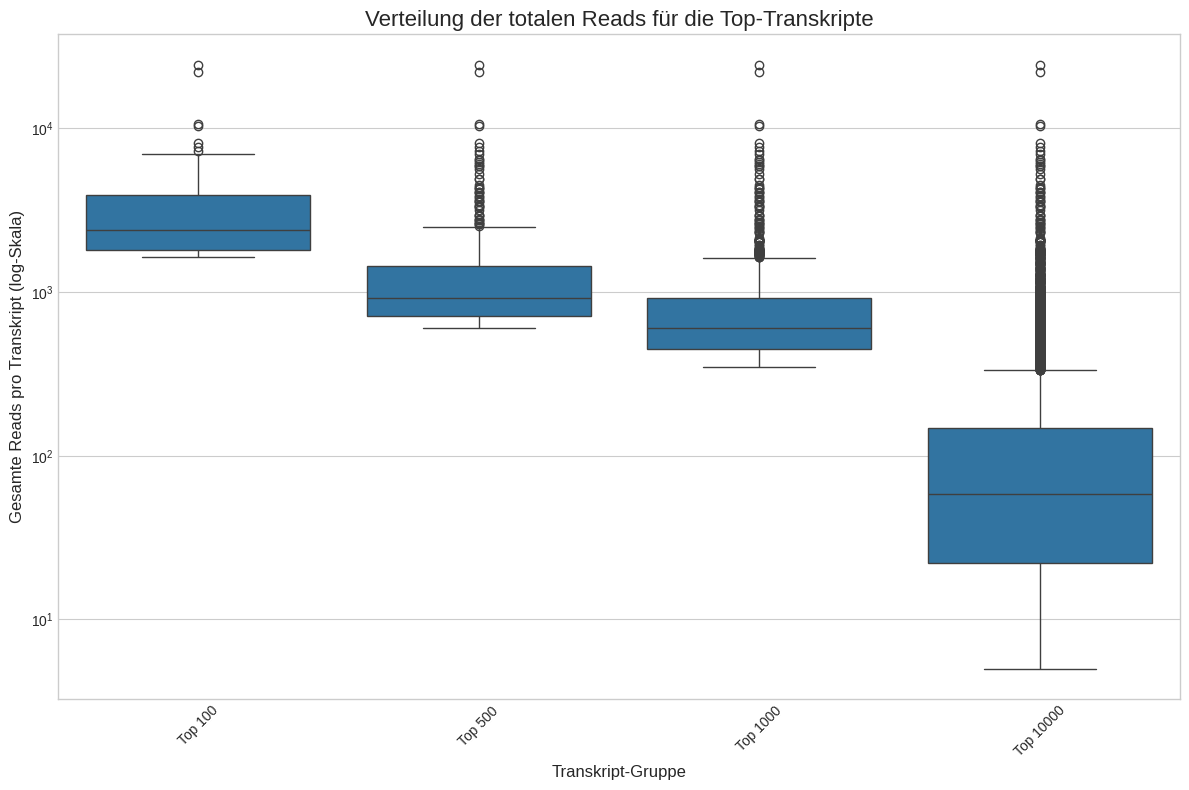

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- Konfiguration ---
# Eingabedatei ist jetzt die verarbeitete .npz-Datei
PROCESSED_DATA_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/ribosome_counts.npz'
OUTPUT_PLOT_FILE = 'read_distribution_boxplot.png'

# --- Hilfsfunktion zum Laden der Daten ---
def load_processed_data(file_path):
    """Lädt die verarbeiteten Daten aus einer .npz-Datei."""
    print(f"Lade verarbeitete Daten von {file_path}...")
    if not os.path.exists(file_path):
        print(f"❌ Fehler: Datendatei nicht gefunden: {file_path}")
        return None
    try:
        data_loader = np.load(file_path, allow_pickle=True)
        transcript_data = {key: data_loader[key] for key in data_loader.files}
        print(f"✅ {len(transcript_data)} Transkripte erfolgreich geladen.")
        return transcript_data
    except Exception as e:
        print(f"❌ Fehler beim Laden der .npz-Datei: {e}")
        return None

# 1. Lade die verarbeiteten Daten (Dictionary von NumPy-Arrays)
processed_data = load_processed_data(PROCESSED_DATA_FILE)

if not processed_data:
    print("Skript wird beendet, da keine Daten geladen werden konnten.")
    exit()

# 2. Berechne die Gesamtanzahl der Reads pro Transkript aus dem Dictionary
print("Berechne Gesamt-Reads pro Transkript aus den Array-Daten...")
# Wir erstellen ein Dictionary, das jeder transcript_id die Summe ihres read-Arrays zuordnet
total_per_transcript = {
    tid: np.sum(reads_array) 
    for tid, reads_array in processed_data.items()
}

# 3. Konvertiere in einen DataFrame und sortiere
# Wir konvertieren das Dictionary in einen DataFrame für die weitere Verarbeitung
total_df = pd.DataFrame.from_dict(total_per_transcript, orient='index', columns=['total_reads'])
sorted_counts_df = total_df.sort_values(by='total_reads', ascending=False)

# 4. Bereite die Daten für den Boxplot vor
print("Stelle die Daten für die Visualisierung zusammen...")
tiers = [100, 500, 1000, 10000] # Obergrenze auf 10000 erhöht für mehr Kontext
plot_data = []
# Wir verwenden hier eine effizientere Methode, um die Plot-Daten zu erstellen
for n in tiers:
    # .head(n) nimmt die Top n Transkripte nach der Sortierung
    top_n_df = sorted_counts_df.head(n).copy()
    top_n_df['Kategorie'] = f'Top {n}'
    plot_data.append(top_n_df)

plot_df = pd.concat(plot_data)
# Umbenennen der Spalte für den Plot
plot_df.rename(columns={'total_reads': 'Reads'}, inplace=True)


# 5. Erstelle den Boxplot
print("Zeichne den Boxplot...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.boxplot(
    data=plot_df,
    x='Kategorie',
    y='Reads',
    order=[f'Top {n}' for n in tiers],
    ax=ax
)

ax.set_yscale('log')
ax.set_title('Verteilung der totalen Reads für die Top-Transkripte', fontsize=16)
ax.set_xlabel('Transkript-Gruppe', fontsize=12)
ax.set_ylabel('Gesamte Reads pro Transkript (log-Skala)', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_PLOT_FILE)
print(f"✅ Boxplot wurde erfolgreich in '{OUTPUT_PLOT_FILE}' gespeichert.")

Lade verarbeitete Daten von /home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/ribosome_counts.npz...
✅ 18640 Transkripte erfolgreich geladen.
Ermittle das Top-Transkript...
Das ausgewählte Transkript ist: ENST00000216281.13
Zeichne den Line-Chart...
✅ Line-Chart wurde erfolgreich in 'top_transcript_read_distribution.png' gespeichert.


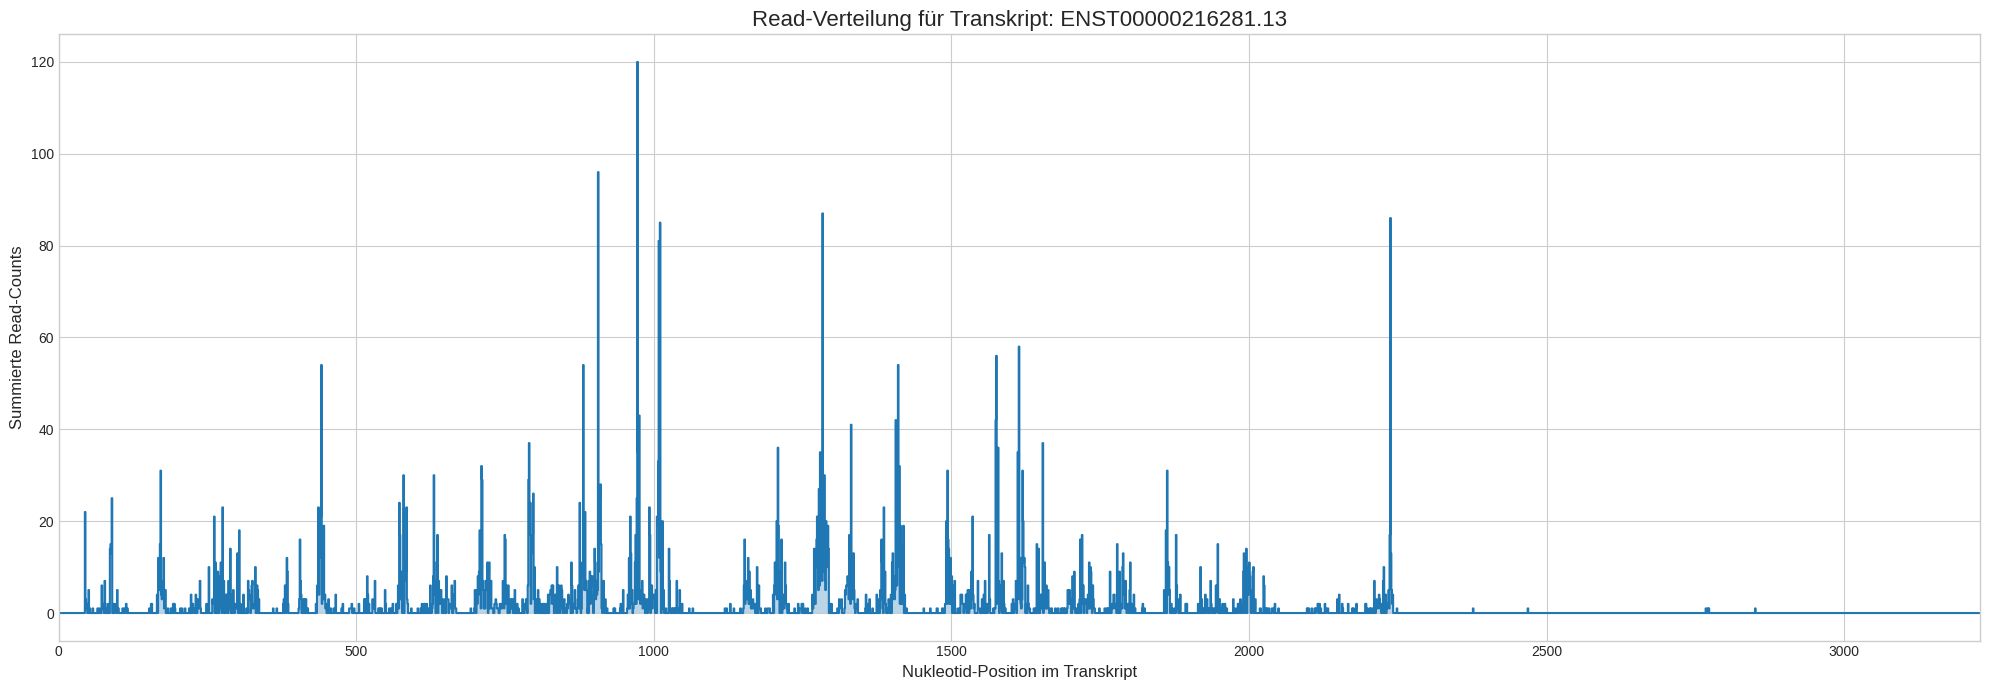

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- Konfiguration ---
PROCESSED_DATA_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/ribosome_counts.npz'
OUTPUT_PLOT_FILE = 'top_transcript_read_distribution.png'

# --- Hilfsfunktion zum Laden der Daten ---
def load_processed_data(file_path):
    """Lädt die verarbeiteten Daten aus einer .npz-Datei."""
    print(f"Lade verarbeitete Daten von {file_path}...")
    if not os.path.exists(file_path):
        print(f"❌ Fehler: Datendatei nicht gefunden: {file_path}")
        return None
    try:
        data_loader = np.load(file_path, allow_pickle=True)
        transcript_data = {key: data_loader[key] for key in data_loader.files}
        print(f"✅ {len(transcript_data)} Transkripte erfolgreich geladen.")
        return transcript_data
    except Exception as e:
        print(f"❌ Fehler beim Laden der .npz-Datei: {e}")
        return None

# 1. Lade die verarbeiteten Daten
processed_data = load_processed_data(PROCESSED_DATA_FILE)

if not processed_data:
    print("Skript wird beendet, da keine Daten geladen werden konnten.")
    exit()

# 2. Finde die ID des Transkripts mit den meisten Reads
print("Ermittle das Top-Transkript...")
# Berechne die Gesamt-Reads pro Transkript, falls noch nicht geschehen
total_per_transcript = {
    tid: np.sum(reads_array) 
    for tid, reads_array in processed_data.items()
}
total_df = pd.DataFrame.from_dict(total_per_transcript, orient='index', columns=['total_reads'])
sorted_counts_df = total_df.sort_values(by='total_reads', ascending=False)

# Wähle das Transkript an einer bestimmten Stelle der sortierten Liste
# Ändere den Index (z.B., 0 für das Top-Transkript, 100 für das 101-beste etc.)
transcript_index_to_plot = 10 
top_transcript_id = sorted_counts_df.index[transcript_index_to_plot]
print(f"Das ausgewählte Transkript ist: {top_transcript_id}")

# 3. Bereite die Daten für dieses eine Transkript für den Plot vor
# Wir holen das NumPy-Array für die ID und erstellen einen DataFrame daraus
reads_array = processed_data[top_transcript_id]
plot_df = pd.DataFrame({
    'position': np.arange(len(reads_array)),
    'total_reads': reads_array
})

# 4. Erstelle den Line-Chart
print("Zeichne den Line-Chart...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 7))

sns.lineplot(
    data=plot_df,
    x='position',
    y='total_reads',
    ax=ax,
    drawstyle='steps-pre' # 'steps-pre' kann für Count-Daten visuell ansprechender sein
)

ax.set_title(f'Read-Verteilung für Transkript: {top_transcript_id}', fontsize=16)
ax.set_xlabel('Nukleotid-Position im Transkript', fontsize=12)
ax.set_ylabel('Summierte Read-Counts', fontsize=12)
ax.set_xlim(0, len(reads_array)) # Setze die x-Achsen-Grenzen auf die volle Länge

# Fülle den Bereich unter der Kurve für bessere Sichtbarkeit
ax.fill_between(plot_df['position'], plot_df['total_reads'], alpha=0.3, step='pre')

plt.tight_layout()
plt.savefig(OUTPUT_PLOT_FILE)
print(f"✅ Line-Chart wurde erfolgreich in '{OUTPUT_PLOT_FILE}' gespeichert.")

In [31]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# --- Konfiguration ---
INPUT_NPZ_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/ribosome_counts.npz'
OUTPUT_TOP_1000_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/top_1000_transcripts.npz'
OUTPUT_REMAINING_FILE = '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/remaining_transcripts.npz'

def save_data_to_npz(data_dict, file_path):
    """Speichert ein Dictionary mit NumPy-Arrays komprimiert im .npz-Format."""
    print(f"Speichere {len(data_dict)} Transkripte in '{file_path}'...")
    np.savez_compressed(file_path, **data_dict)
    print("✅ Speichern abgeschlossen.")

# --- Hauptskript ---
if __name__ == "__main__":
    # 1. Lade die vollständigen, verarbeiteten Daten
    all_data = load_processed_data(INPUT_NPZ_FILE)

    if not all_data:
        print("Skript wird beendet, da keine Eingabedaten geladen werden konnten.")
        exit()

    # 2. Berechne die Gesamt-Reads pro Transkript
    print("Berechne die Gesamt-Reads pro Transkript...")
    total_per_transcript = {
        tid: np.sum(reads_array)
        for tid, reads_array in tqdm(all_data.items(), desc="Summiere Reads")
    }
    
    # 3. Sortiere die Transkripte nach der Gesamt-Read-Anzahl
    total_df = pd.DataFrame.from_dict(total_per_transcript, orient='index', columns=['total_reads'])
    sorted_transcripts = total_df.sort_values(by='total_reads', ascending=False)

    # 4. Identifiziere die Top 1000
    if len(sorted_transcripts) >= 1000:
        threshold_read_count = sorted_transcripts.iloc[999]['total_reads']
        print("-" * 50)
        print(f"Die Read-Anzahl des 1000. Transkripts (Schwellenwert) ist: {threshold_read_count}")
        print("-" * 50)
        top_1000_ids = set(sorted_transcripts.head(1000).index)
    else:
        print("Warnung: Weniger als 1000 Transkripte vorhanden. Alle werden als 'Top' behandelt.")
        top_1000_ids = set(sorted_transcripts.index)

    # 5. Teile die ursprünglichen Dictionary-Daten auf
    print("Teile die Daten in 'Top 1000' und 'Rest' auf...")
    top_1000_data = {}
    remaining_data = {}

    for tid, reads_array in all_data.items():
        if tid in top_1000_ids:
            top_1000_data[tid] = reads_array
        else:
            remaining_data[tid] = reads_array
            
    # 6. Speichere die beiden neuen Dictionaries als separate .npz-Dateien
    save_data_to_npz(top_1000_data, OUTPUT_TOP_1000_FILE)
    save_data_to_npz(remaining_data, OUTPUT_REMAINING_FILE)

    print("\n✅ Aufteilung abgeschlossen!")

Lade verarbeitete Daten von /home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/ribosome_counts.npz...
✅ 18640 Transkripte erfolgreich geladen.
Berechne die Gesamt-Reads pro Transkript...


Summiere Reads: 100%|██████████| 18640/18640 [00:00<00:00, 216669.19it/s]

--------------------------------------------------
Die Read-Anzahl des 1000. Transkripts (Schwellenwert) ist: 351
--------------------------------------------------
Teile die Daten in 'Top 1000' und 'Rest' auf...
Speichere 1000 Transkripte in '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/top_1000_transcripts.npz'...


✅ Speichern abgeschlossen.
Speichere 17640 Transkripte in '/home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/remaining_transcripts.npz'...
✅ Speichern abgeschlossen.

✅ Aufteilung abgeschlossen!


In [32]:
load_processed_data(OUTPUT_TOP_1000_FILE)

Lade verarbeitete Daten von /home/kai/Documents/00_RNA/00_riboHMM_simple/01_Proccesed_Data/top_1000_transcripts.npz...
✅ 1000 Transkripte erfolgreich geladen.


{'ENST00000378609.9': array([0, 0, 0, ..., 0, 0, 0], shape=(3163,), dtype=uint16),
 'ENST00000234875.9': array([0, 0, 0, ..., 0, 0, 0], shape=(2061,), dtype=uint16),
 'ENST00000338639.10': array([0, 0, 0, ..., 0, 0, 0], shape=(1127,), dtype=uint16),
 'ENST00000234590.10': array([0, 0, 1, ..., 0, 0, 0], shape=(1781,), dtype=uint16),
 'ENST00000377298.9': array([0, 0, 0, ..., 0, 0, 0], shape=(4760,), dtype=uint16),
 'ENST00000270776.13': array([0, 0, 0, ..., 0, 0, 0], shape=(2268,), dtype=uint16),
 'ENST00000240185.8': array([0, 0, 0, ..., 0, 0, 0], shape=(4185,), dtype=uint16),
 'ENST00000196061.5': array([0, 0, 0, ..., 0, 0, 0], shape=(2976,), dtype=uint16),
 'ENST00000375254.8': array([0, 0, 0, ..., 0, 0, 0], shape=(15892,), dtype=uint16),
 'ENST00000477853.6': array([0, 0, 2, ..., 0, 0, 0], shape=(6640,), dtype=uint16),
 'ENST00000264202.8': array([0, 0, 0, ..., 0, 0, 0], shape=(1675,), dtype=uint16),
 'ENST00000602624.7': array([5, 0, 0, ..., 0, 0, 0], shape=(1941,), dtype=uint16),
